---
---
# Aesthetics - images by colours
---
---
---
#instagramaesthetics


This notebooks investigates pre-processing steps for one-hot-encoding colours

#### Contents

0. Import packages
1. Define Functions
2. Dictionaries with colour name to hexcode
3. Import & transform images
4. Get dominating colours with KMeans
5. Show results

---
## 0. Import packages
---

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
#!pip install webcolors

In [363]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import pickle
import glob
import os
import ast
from PIL import Image
from PIL import ImageColor
from skimage import io, color
from skimage.color import rgb2lab, deltaE_cie76, deltaE_ciede2000
from scipy.spatial import KDTree
import webcolors

---
## 1. Define Functions 
---

preprocess images

In [335]:
def preprocess_list_of_images(list_of_paths):
  images = [cv2.imread(file) for file in list_of_paths]
  images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
  return [image.reshape((image.shape[0] * image.shape[1], 3)) for image in images]

Colour clustering

In [347]:
 def find_dominant_colours(list_of_paths, n_clstrs=5): 
  images = preprocess_list_of_images(list_of_paths)
  dom=[]
  for i in range(0,len(images)):
      cltr = KMeans(n_clusters = n_clstrs)
      dom.append((list_of_paths[i], cltr.fit(images[i])))
  return dom

plot results of KMeans clustering

In [340]:
def centroid_histogram(clt):
	# grab the number of different clusters and create a histogram
	# based on the number of pixels assigned to each cluster
	numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
	(hist, _) = np.histogram(clt.labels_, bins = numLabels)
	# normalize the histogram, such that it sums to one
	hist = hist.astype("float")
	hist /= hist.sum()
	# return the histogram
	return hist

def plot_colours(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar

# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
def plot_dominating_colours(clt):
    hist = centroid_histogram(clt)
    bar = plot_colours(hist, clt.cluster_centers_)

    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    #plt.savefig(name,dpi=400,bbox_inches='tight')
    plt.show()


def return_bar(clt,name):
    hist = centroid_histogram(clt)
    return plot_colours(hist, clt.cluster_centers_)


def show_nebeneinander(img_clrs):
    for i in range(0,len(img_clrs)):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(cv2.cvtColor(cv2.imread(img_clrs[i][0]), cv2.COLOR_BGR2RGB))
        axarr[0].axis('off')
        axarr[1].imshow(return_bar(img_clrs[i][1], img_clrs[i][0]))
        axarr[1].axis('off')

def simplify_colours(clt):
    bar = np.zeros((1, 100, 3), dtype = "uint8")
    startX = 0
    for (percent, color) in zip(centroid_histogram(clt), clt.cluster_centers_):
        endX = startX + (percent * 100)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 1),
            color.astype("uint8").tolist(), -1)
        startX = endX
    return bar

Convert hex value to colour name

In [296]:
def get_name_of_nearest_colour(dictionary, rgb):
    names = []
    rgb_values = []
    for color_name, color_hex in dictionary.items():
        names.append(color_name)
        rgb_values.append(webcolors.hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(tuple(rgb))
    return print(names[index])

# show names, image and dominant colours
def show_names(img):
   
        print('metadata of image ' + img[0]+':')
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(cv2.cvtColor(cv2.imread(img[0]), cv2.COLOR_BGR2RGB))
        axarr[0].axis('off')
        axarr[1].imshow(return_bar(img[1], img[0]))
        axarr[1].axis('off')
        nms = np.rint(img[1].cluster_centers_).astype(int)
        for cl in nms:
          get_name_of_nearest_colour(dict_most, cl)

---
## 2. Dictionaries with colour name to hexcode
---

In [289]:
with open('/content/drive/MyDrive/data/aesthetics/rgb.txt') as f:
    lines = f.readlines()
    lines = [ line.replace('\t\n', '').replace('\t', ',').split(',') for line in lines[1:]]
    #lines = [ [line[0], list(ImageColor.getcolor(line[1], "RGB"))] for line in lines]
    dict_classic = dict(lines)

In [290]:
with open('/content/drive/MyDrive/data/aesthetics/rgbslices.txt') as f:
    lines_slices = f.readlines()
    lines_slices = [ line.replace('\n', '').replace('] ', '];').split(';')[::-1]  for line in lines_slices[1:]]
    lines_slices = [ [line[0], webcolors.rgb_to_hex(tuple(ast.literal_eval(line[1])))] for line in lines_slices]
    dict_slices = dict(lines_slices)

In [294]:
dict_classic.update(dict_slices)
dict_classic.update(webcolors.CSS3_NAMES_TO_HEX)

In [295]:
dict_most = dict_classic

---
## 3. Import & transform images
---

In [6]:
path = 'drive/MyDrive/data/aesthetics/investigating-aesthetics/'

In [7]:
os.chdir(path)

For improving performance, we first downsize the images

In [281]:
image_names=glob.glob("*.*")
#image_names

---
## 4. Get dominating colours with KMeans
---

In [353]:
images_colours = find_dominant_colours(image_names, 20)

In [373]:
#show_nebeneinander(images_colours)

In [32]:
colour_values = np.rint(images_colours[i][1].cluster_centers_).astype(int)  
anzahl_array = centroid_histogram(images_colours[i][1])*100

array([[140.40741666, 111.95351063,  86.07341741],
       [230.29536395, 215.20864959, 201.19046579],
       [249.53072388, 247.52965033, 246.53109877],
       [ 61.1020786 ,  43.79996634,  33.1800892 ],
       [193.39621921, 161.88094329, 133.20520654],
       [167.89178205, 137.89009437, 109.81538885],
       [212.58391989, 185.98766418, 162.12539003],
       [105.5090573 ,  81.31540357,  61.88065311]])

---
## 5. Show results
---

metadata of image ae1a.png:
snow
putty
cocoa
pale brown
wheat
chocolate brown
greyish brown
dull brown
dark grey
pale brown
puce
wheat
mushroom
gainsboro
brown grey
fawn
tan
linen
silver
purple brown


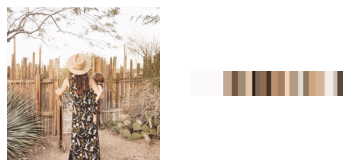

In [370]:
show_names(images_colours[0])

metadata of image ae3c.png:
charcoal grey
gainsboro
darkgray
almost black
medium grey
light peach
silver
pale brown
snow
dark grey
light grey
black
gunmetal
tan
cement
cocoa
pinkish brown
whitesmoke
bisque
dark


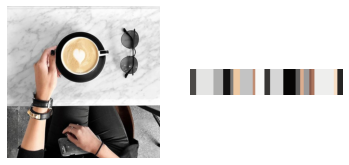

In [371]:
show_names(images_colours[10])

metadata of image ae4h.png:
lightgray
gunmetal
cool grey
lavender
almost black
light blue grey
brownish purple
blue/grey
gainsboro
brownish grey
dark
pinkish grey
light grey blue
gainsboro
stone
warm grey
battleship grey
purple brown
silver
charcoal grey


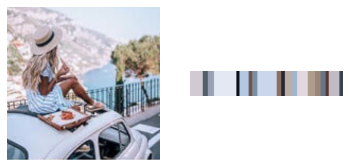

In [376]:
show_names(images_colours[19])